LWA Flux Hovmoller with contour of difference: 100%|██████████| 360/360 [00:22<00:00, 16.27it/s]


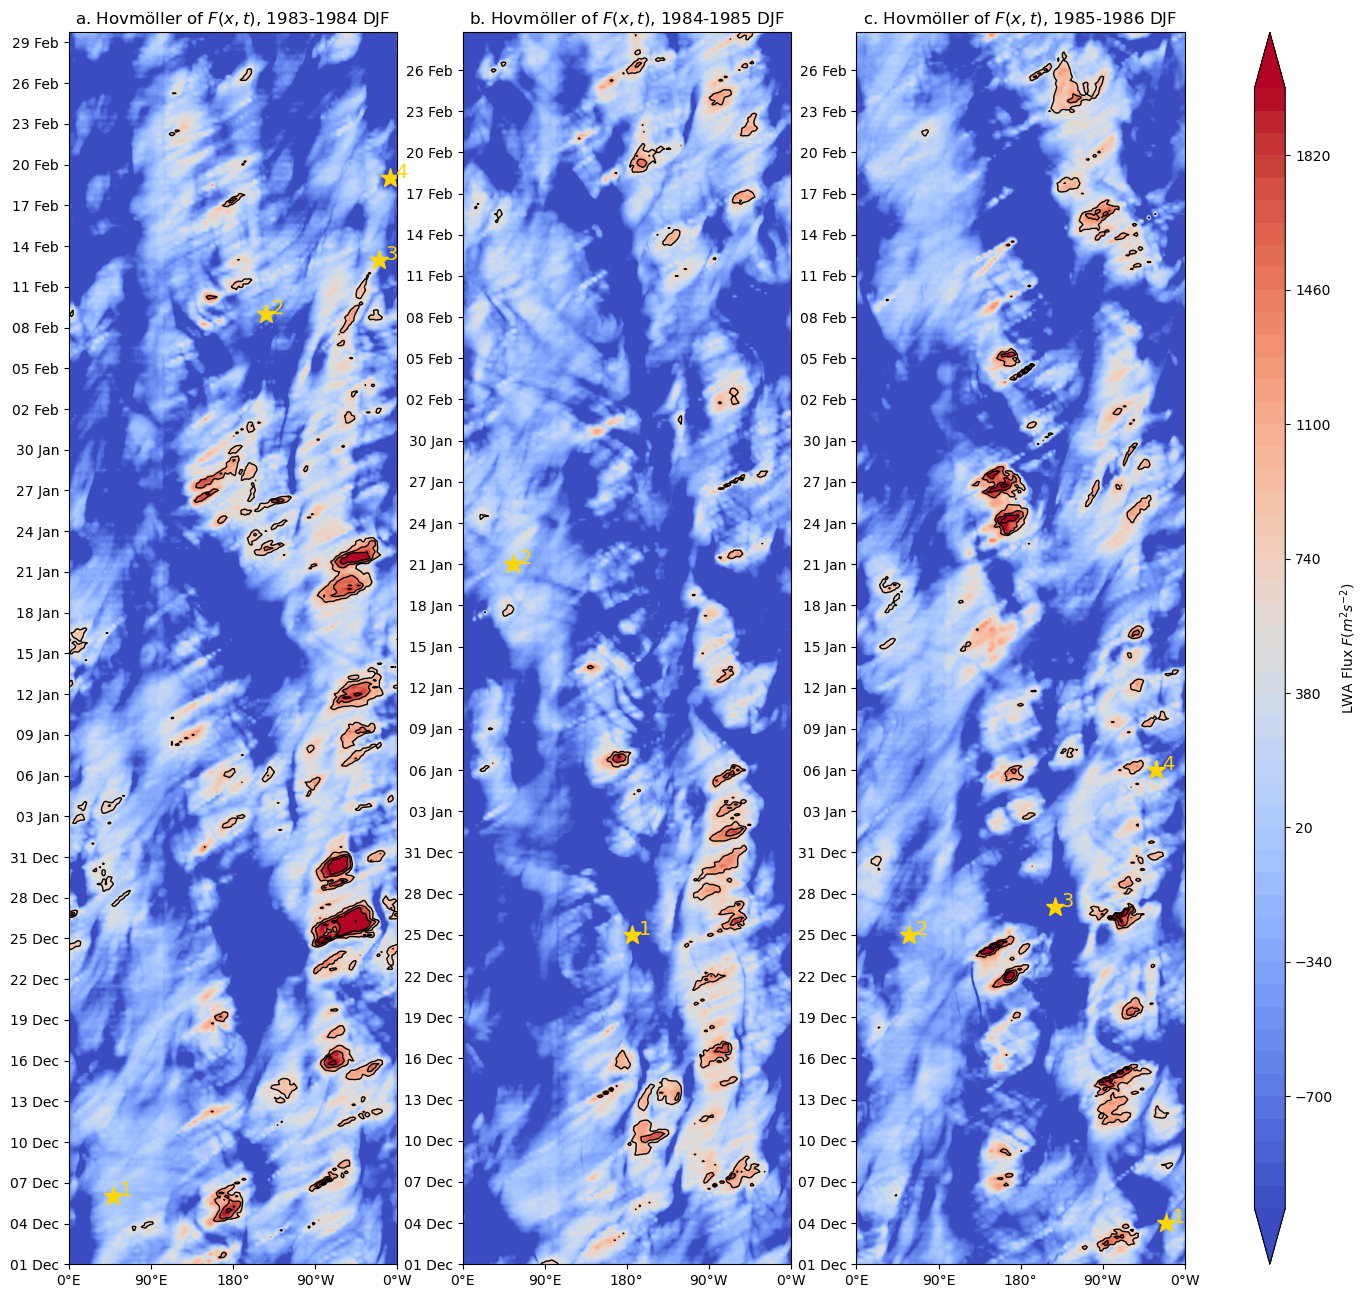

In [1]:
# 0421 version fig 3 - LWA hovmoller, exceedance contour

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def main():
    input_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/depot/wanglei/etc/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')

    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(1983, 12, 1, 0), datetime(1984, 2, 29, 18)),
        (datetime(1984, 12, 1, 0), datetime(1985, 2, 28, 18)),
        (datetime(1985, 12, 1, 0), datetime(1986, 2, 28, 18))
        # (datetime(1986, 12, 1, 0), datetime(1987, 2, 28, 18)),
        # (datetime(1987, 12, 1, 0), datetime(1988, 2, 29, 18))
    ]
    time_delta = timedelta(hours=6)

    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 3, figsize=(18, 16))
    last_contour = None  # Placeholder for the last contour object

    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes

        # Wrap the loop with tqdm for a progress bar
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="LWA Flux Hovmoller with contour of difference"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros((121, 240))  # np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                nh_avg_flux = np.mean(total_flux[80:101, :], axis=0)
                hovmoller_data[i, :] = nh_avg_flux


        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        cf = ax.contourf(X, Y, hovmoller_data, levels=np.linspace(-1000, 2000, 51), cmap='coolwarm', extend='both')
        # Calculate and plot contours for flux differences
        flux_difference = hovmoller_data - np.mean(flux_capacity_2d[80:101, :], axis=0)  # Assuming avg capacity for contour
        ax.contour(X, Y, flux_difference, levels=[100, 650, 1200], colors='black', linewidths=1)

        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        # ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of LWA Flux $F(x,t)$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of $F(x,t)$, {start_time.strftime('%Y')}-{end_time.strftime('%Y')} DJF")

        ytick_step_size = 12
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)
        
    fig.colorbar(cf, ax=axs, location='right', aspect=40, label='LWA Flux $F (m^2s^{-2}$)')
    # plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()

/home/yan481/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yan481/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
100%|██████████| 234/234 [00:03<00:00, 69.57it/s] 
/tmp/ipykernel_3015153/2539434371.py:265: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


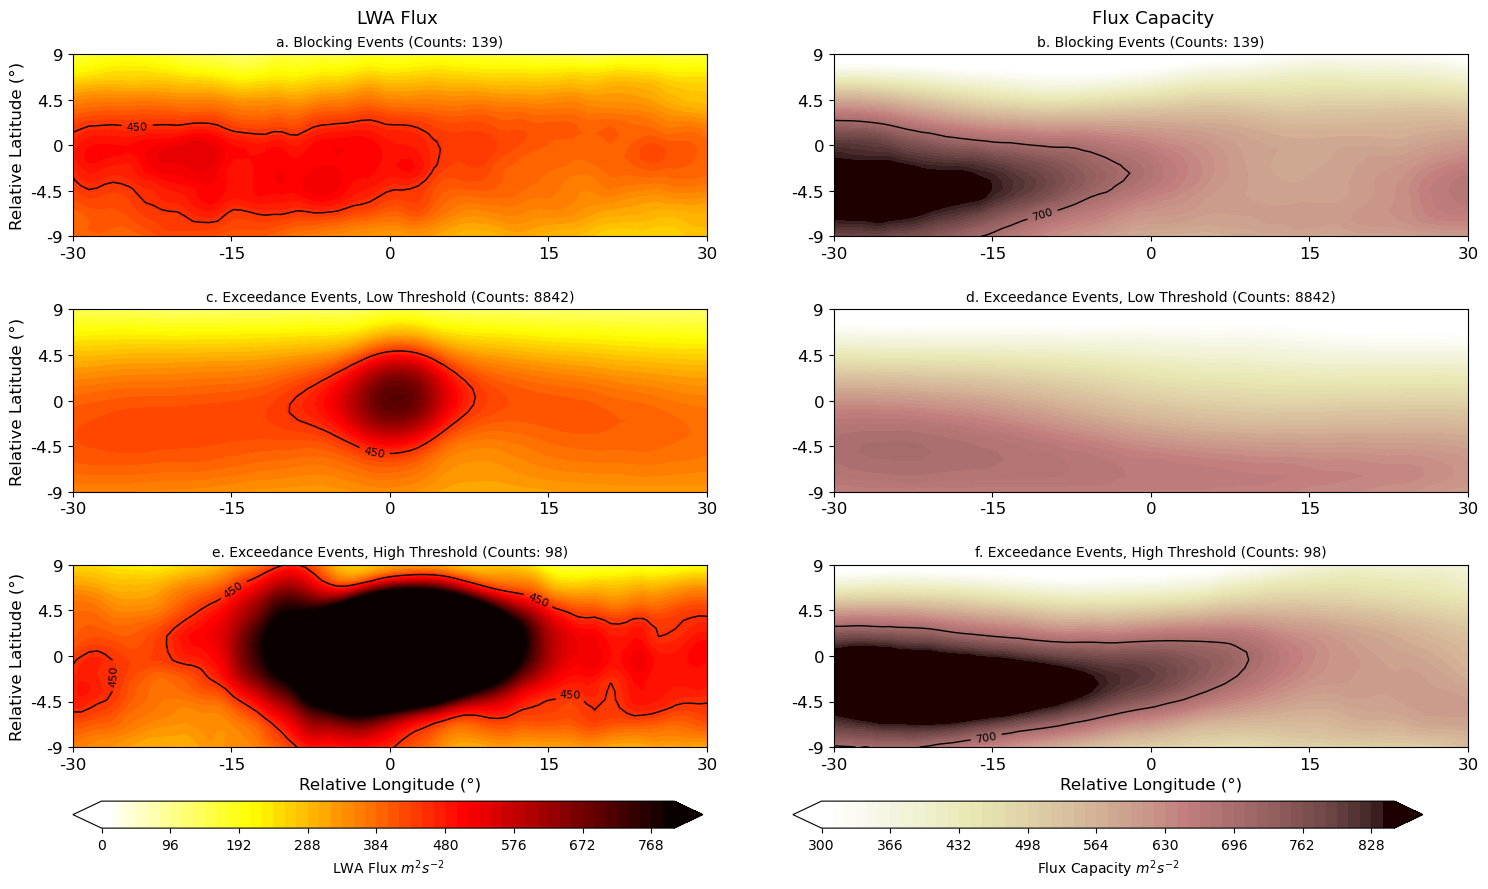

In [5]:
### FIG4 0814 ver - contourf, different cmap, 3 columns, addtional lon lat on the left and bottom

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import FancyArrow


# Load Flux Capacity Data
flux_capacity_path = "/depot/wanglei/etc/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/depot/wanglei/etc/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block1 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    extracted_block2 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block1[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            extracted_block2[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1_flux = np.percentile(extracted_block1, 2)
    percentile_99_flux = np.percentile(extracted_block1, 98)
    extracted_block1 = np.clip(extracted_block1, percentile_1_flux, percentile_99_flux)
    
    percentile_1_cap = np.percentile(extracted_block2, 2)
    percentile_99_cap = np.percentile(extracted_block2, 98)
    extracted_block2 = np.clip(extracted_block2, percentile_1_cap, percentile_99_cap)
    return event_type, extracted_block1, extracted_block2, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV for regular analysis
results_df = pd.read_csv('/depot/wanglei/etc/KenYan_Traffic_Model/reproduce241016/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')

# Read the results CSV for the high threshold analysis
results_df_high_threshold = pd.read_csv('/depot/wanglei/etc/KenYan_Traffic_Model/reproduce241016/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite1_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_non_match = np.zeros((24, 80))
composite1_heatmap_exceedance = np.zeros((24, 80))
composite1_heatmap_both = np.zeros((24, 80))

# Initialize separate heatmaps for each event type
composite2_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_non_match = np.zeros((24, 80))
composite2_heatmap_exceedance = np.zeros((24, 80))
composite2_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite1_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite1_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite1_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite2_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite2_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite2_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate Heaviside_high_threshold blocks for each event type
composite_Heaviside_high_threshold_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_non_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_exceedance = np.zeros((24, 80))
composite_Heaviside_high_threshold_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0
count_high_threshold_match, count_high_threshold_non_match, count_high_threshold_exceedance, count_high_threshold_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite1_heatmap_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_match += 1
        count_exceedance += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_non_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_non_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite1_heatmap_match /= count_match if count_match else 1
composite1_heatmap_non_match /= count_non_match if count_non_match else 1
composite1_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite1_heatmap_both /= count_both if count_both else 1

composite2_heatmap_match /= count_match if count_match else 1
composite2_heatmap_non_match /= count_non_match if count_non_match else 1
composite2_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite2_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Use Joblib to process events in parallel and extract the blocks for both datasets
for row in tqdm(results_df_high_threshold.itertuples(index=False), total=len(results_df_high_threshold)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )

    if event_type == 'Match':
        composite1_heatmap_high_threshold_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1
        count_high_threshold_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_high_threshold_non_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_non_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_non_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        count_high_threshold_non_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1

# Calculate the averages for the composite heatmap_high_threshold
composite1_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite1_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite1_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite1_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite2_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite2_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite2_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite2_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite_Heaviside_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite_Heaviside_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite_Heaviside_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite_Heaviside_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1



# Updated plotting function that takes a cmap parameter
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap, add_lat_label=False, add_lon_label=False):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', '0', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', '0', '4.5', '9'], fontsize=12)
    
    # Add y-axis label if specified
    if add_lat_label:
        ax.set_ylabel("Relative Latitude (°)", fontsize=12)

    # Add x-axis label if specified
    if add_lon_label:
        ax.set_xlabel("Relative Longitude (°)", fontsize=12)

    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4) 

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 850, 51), ncolors=256, clip=True)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite1_heatmap_both, f"a. Blocking Events (Counts: {count_both})", count_both, norm=norm_upper, levels=[450], cmap=cmap_upper, add_lat_label=True)
ax2 = fig.add_subplot(gs[1, 0])
contour2 = plot_composite_heatmap(ax2, composite1_heatmap_exceedance, f"c. Exceedance Events, Low Threshold (Counts: {count_exceedance})", count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper, add_lat_label=True)

ax3 = fig.add_subplot(gs[0, 1])
contour3 = plot_composite_heatmap(ax3, composite2_heatmap_both, f"b. Blocking Events (Counts: {count_both})", count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)
ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite2_heatmap_exceedance, f"d. Exceedance Events, Low Threshold (Counts: {count_exceedance})", count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax5 = fig.add_subplot(gs[2, 0])
contour5 = plot_composite_heatmap(ax5, composite1_heatmap_high_threshold_exceedance, f"e. Exceedance Events, High Threshold (Counts: {count_high_threshold_exceedance})", count_high_threshold_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper, add_lat_label=True, add_lon_label=True)
ax6 = fig.add_subplot(gs[2, 1])
contour6 = plot_composite_heatmap(ax6, composite2_heatmap_high_threshold_exceedance, f"f. Exceedance Events, High Threshold (Counts: {count_high_threshold_exceedance})", count_high_threshold_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower, add_lon_label=True)

# Colorbars at the bottom
cbar_ax1 = fig.add_axes([0.125, 0.02, 0.35, 0.03])  # x position, y position, width, height
fig.colorbar(contour1, cax=cbar_ax1, orientation='horizontal').set_label("LWA Flux $m^2s^{-2}$")
cbar_ax2 = fig.add_axes([0.525, 0.02, 0.35, 0.03])
fig.colorbar(contour3, cax=cbar_ax2, orientation='horizontal').set_label("Flux Capacity $m^2s^{-2}$")

plt.figtext(0.305, 0.92, f'LWA Flux', ha='center', va='center', fontsize=13)
plt.figtext(0.725, 0.92, f'Flux Capacity', ha='center', va='center', fontsize=13)

plt.show()
